# Exploration - SMART METER LONDON

## Objective of this Notebook
- Dataset description
- Basic descriptive analysis

In [1]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

from python_code.data_preparation import load_series

### Data Description
In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption.


A detailed data description can be found on Kaggle: [Kaggle: Smart Meters in London](https://www.kaggle.com/jeanmidev/smart-meters-in-london).

### Data Preparation

This dataset was prepared in that way that we have full series and each series starts and ends from the same time stamp.

The full and "dirty" time series 
![Full Series](../images/smart_meter_heatmap.png)

are filtered to some nicer subset
![Full Series](../images/smart_meter_heatmap_max_date_same_start.png)

After cleaning the dataset, we have 

This dataset contains 4961 series with data range from 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days.)

### Data Description

In [2]:
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"

file = 'smart_meters_london_cleaned_same_start.csv.gz'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)

df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14406744 entries, 2013-10-30 00:00:00+01:00 to 2014-02-27 23:00:00+01:00
Data columns (total 2 columns):
id        object
energy    float64
dtypes: float64(1), object(1)
memory usage: 329.7+ MB


The data was saved with `write_csv` from the `readr` package. Date variables are saved in UTC time zone. Therefore, we have to realign the date column. 

In [4]:
df.head()

,id,energy
date,,
2013-10-30 00:00:00+01:00,MAC000002,0.457
2013-10-30 01:00:00+01:00,MAC000002,0.414
2013-10-30 02:00:00+01:00,MAC000002,0.408
2013-10-30 03:00:00+01:00,MAC000002,0.352
2013-10-30 04:00:00+01:00,MAC000002,0.250


In [5]:
uniqueIDs = df['id'].unique()
len(uniqueIDs)

4961

# Extracting Time Series Features 
We extract some time series features like mean, variance, lumpiness for each household series. With these Features we want to cluster our time series to identify diffent types of time series. Afterwards the representants for each cluster are analysed regarding trend, seasonality, etc.  

## Time series features based on tiled windows
Computes features of a time series based on tiled (non-overlapping) windows. 
Means or variances are produced for all tiled windows. Then **stability** is the variance of the means, while **lumpiness** is the variance of the variances.

In [6]:
def stability(s: pd.Series, width=24):
    lenght_of_series = len(series)
    number_of_groups = math.ceil(lenght_of_series/width)
    grouper = np.array([[i]* width for i in range(number_of_groups)])\
                .reshape((number_of_groups* width, 1))[:lenght_of_series,:]
    df = pd.DataFrame(s)
    df['grouper'] = grouper
    grouped_df = df.groupby(df['grouper']).mean()
    
    return grouped_df.var()

In [7]:
def lumpiness(s: pd.Series, width=24):
    lenght_of_series = len(series)
    number_of_groups = math.ceil(lenght_of_series/width)
    grouper = np.array([[i]* width for i in range(number_of_groups)])\
                .reshape((number_of_groups* width, 1))[:lenght_of_series,:]
    df = pd.DataFrame(s)
    df['grouper'] = grouper
    grouped_df = df.groupby(df['grouper']).var()
    
    return grouped_df.var()

In [8]:
series = df[df['id']=='MAC000005']['energy']

In [9]:
stability(series, 24)

energy    0.003367
dtype: float64

In [10]:
lumpiness(series, 24)

energy    0.005931
dtype: float64

## Time Series features based on sliding windows
Computes features of a time series based on sliding (overlapping) windows.
**max_level_shift** finds the largest mean shift between two consecutive windows. 
**max_var_shift** finds the largest var shift between two consequtive windows.


In [11]:
def max_level_shift(s: pd.Series, width = 5):
    rolling_mean = s.rolling(width).mean()
    max_mean_shift_abs_diff = rolling_mean.diff().abs().max()
    return max_mean_shift_abs_diff

In [12]:
def max_var_shift(s: pd.Series, width = 24):
    rolling_var = s.rolling(width).var()
    max_var_shift_abs_diff = rolling_var.diff().abs().max()
    return max_var_shift_abs_diff

## Number of crossing points
Cumputes the number of times a time series crosses the median. 

In [13]:
def crossing_points(s: pd.Series):
    median = s.median()
    lower_median = s <= median
    cross = ((~lower_median).shift() & lower_median )| (lower_median.shift() & (~lower_median) )
    return sum(cross)     

In [14]:
crossing_points(series)

755

In [15]:
def ratio_beyond_r_sigma(x, r):
    """
    Ratio of values that are more than r*std(x) (so r sigma) away from the mean of x.
    :param x: the time series to calculate the feature of
    :type x: iterable
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.sum(np.abs(x - np.mean(x)) > r * np.std(x))/x.size

In [16]:
def abs_energy(x):
    """
    Returns the absolute energy of the time series which is the sum over the squared values
    .. math::
        E = \\sum_{i=1,\ldots, n} x_i^2
    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.dot(x, x)

### Create Feature Matrix

In [17]:
feature_matrix = df.groupby('id')['energy'].agg(['mean', crossing_points])

feature_matrix['lumpiness_5'] = df.groupby('id').apply(lambda s: lumpiness(s, width=5))
feature_matrix['max_var_shift_10'] = df['energy'].groupby(df['id']).apply(lambda s: max_var_shift(s, width=10))
feature_matrix['ratio_beyond_1_std'] = df['energy'].groupby(df['id']).apply(lambda s: ratio_beyond_r_sigma(s, 1))

In [18]:
feature_matrix.corr()

,mean,crossing_points,lumpiness_5,max_var_shift_10,ratio_beyond_1_std
mean,1.000000,-0.205468,0.243240,0.592375,0.359188
crossing_points,-0.205468,1.000000,0.033286,-0.071982,-0.129883
lumpiness_5,0.243240,0.033286,1.000000,0.588151,-0.014175
max_var_shift_10,0.592375,-0.071982,0.588151,1.000000,-0.042850
ratio_beyond_1_std,0.359188,-0.129883,-0.014175,-0.042850,1.000000


In [19]:
abs(feature_matrix.corr() ) < 0.6

,mean,crossing_points,lumpiness_5,max_var_shift_10,ratio_beyond_1_std
mean,False,True,True,True,True
crossing_points,True,False,True,True,True
lumpiness_5,True,True,False,True,True
max_var_shift_10,True,True,True,False,True
ratio_beyond_1_std,True,True,True,True,False


# Clustering according to time series features

## Principle Component Analysis

### Normalize features before using PCA
Before we apply PCA, we scale our features so that each feature has unit variance usind StandardScaler

In [20]:
scaler = StandardScaler()
scaler.fit(feature_matrix)
features_scaled = scaler.transform(feature_matrix)

In [21]:
feature_labels = feature_matrix.columns

In [22]:
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_labels, index=feature_matrix.index)
features_scaled_df.describe()

,mean,crossing_points,lumpiness_5,max_var_shift_10,ratio_beyond_1_std
count,4.961000e+03,4.961000e+03,4.961000e+03,4.961000e+03,4.961000e+03
mean,2.134511e-16,-4.338172e-17,-9.200573e-18,-2.663103e-17,-1.245840e-16
std,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00
min,-1.249691e+00,-2.965292e+00,-1.049382e-01,-7.551803e-01,-1.940610e+00
25%,-6.250013e-01,-5.484572e-01,-1.036172e-01,-5.376658e-01,-6.526408e-01
50%,-2.565684e-01,-1.541560e-01,-9.833711e-02,-2.862651e-01,-2.679226e-01
75%,3.046652e-01,3.421996e-01,-7.873703e-02,1.576254e-01,3.635171e-01
max,1.208016e+01,9.049298e+00,3.593088e+01,2.131791e+01,6.042293e+00


In [23]:
pca = PCA(n_components=2)
pca.fit(features_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
print(pca.explained_variance_ratio_)

[0.40404365 0.25532474]


Text(0,0.5,'Principle components')

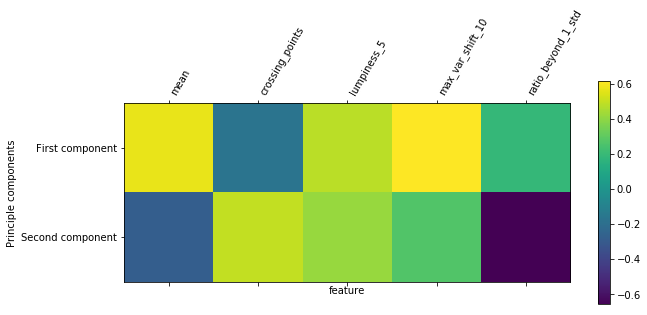

In [25]:
plt.matshow(pca.components_)
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(feature_labels)), feature_labels, rotation=60, ha='left')
plt.xlabel('feature')
plt.ylabel('Principle components')

In [26]:
transformed_features = pca.transform(features_scaled)

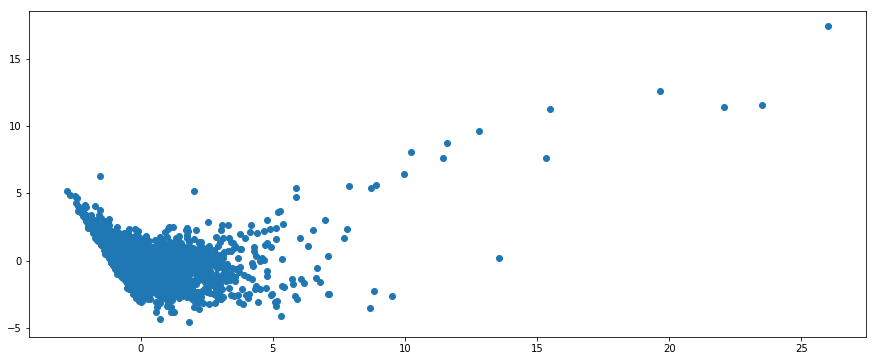

In [27]:
plt.figure(figsize=(15,6))
plt.scatter(transformed_features[:,0], transformed_features[:,1])

## K-Means Clustering

In [28]:
kmeans = KMeans(n_clusters= 4, random_state=0)
kmeans.fit(features_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

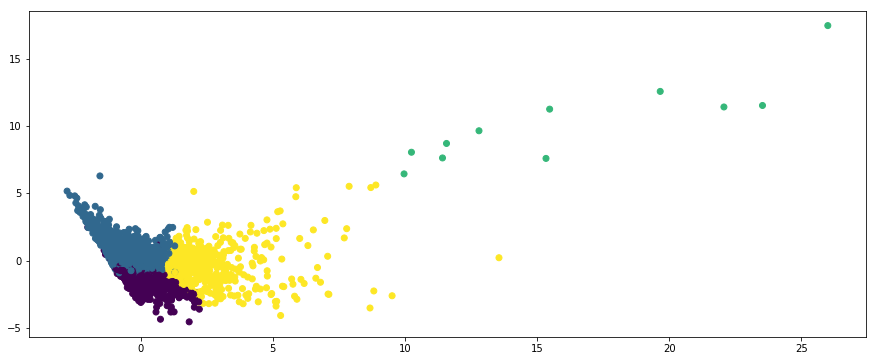

In [29]:
plt.figure(figsize=(15,6))
plt.scatter(transformed_features[:,0], transformed_features[:,1], c= kmeans.labels_)

### Colored Scatter Plot

In [30]:
features_scaled_df['labels'] = kmeans.labels_

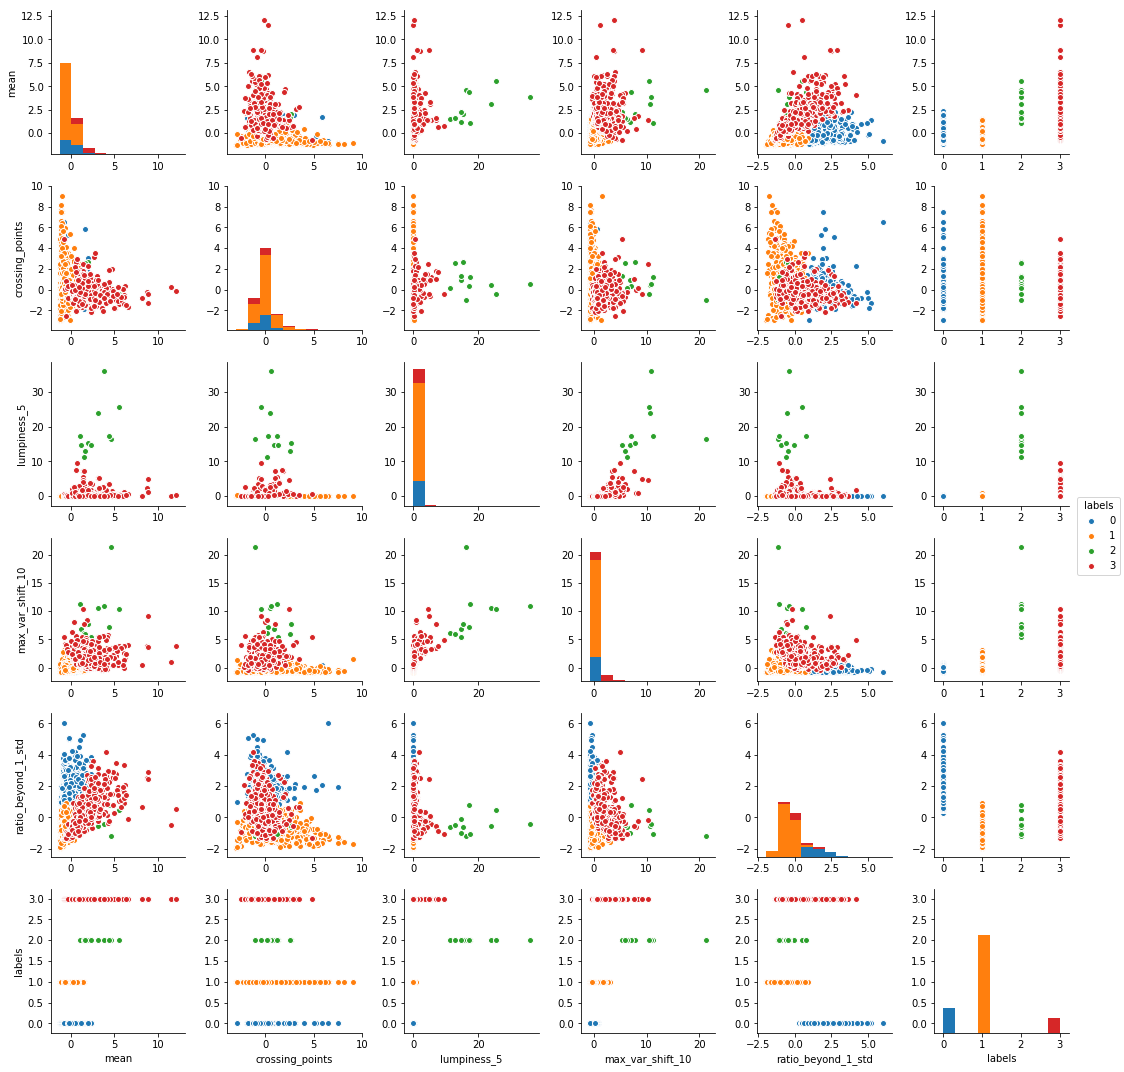

In [31]:
sns.pairplot(features_scaled_df, hue='labels')

## Analysing the Representatives for each cluster
One Representative for each cluster is identified. These are marked with a cross in the plot below. Then a ARIMA(2,1,0) model is fitted to the each series of the representative.

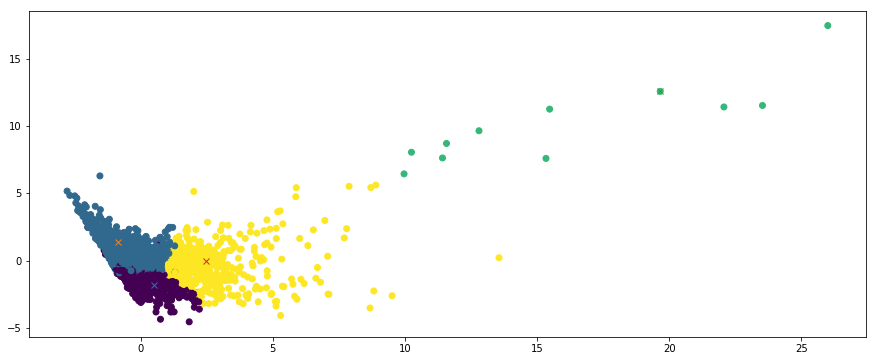

In [32]:
plt.figure(figsize=(15,6))
plt.scatter(transformed_features[:,0], transformed_features[:,1], c= kmeans.labels_)

rep_0 = pca.transform([features_scaled_df.loc['MAC000022'][feature_labels]])
plt.plot(rep_0[:,0], rep_0[:,1], marker = 'x')

rep_1 = pca.transform([features_scaled_df.loc['MAC000349'][feature_labels]])
plt.plot(rep_1[:,0], rep_1[:,1], marker = 'x')

rep_2 = pca.transform([features_scaled_df.loc['MAC000034'][feature_labels]])
plt.plot(rep_2[:,0], rep_2[:,1], marker = 'x')

rep_3 = pca.transform([features_scaled_df.loc['MAC002321'][feature_labels]])
plt.plot(rep_3[:,0], rep_3[:,1], marker = 'x')

### Cluster 0
Using the houshold MAC000022 as a representative for cluster 0, we analyse the series using ARIMA. 

In [33]:
series = df[df['id'] == 'MAC000022']['energy']

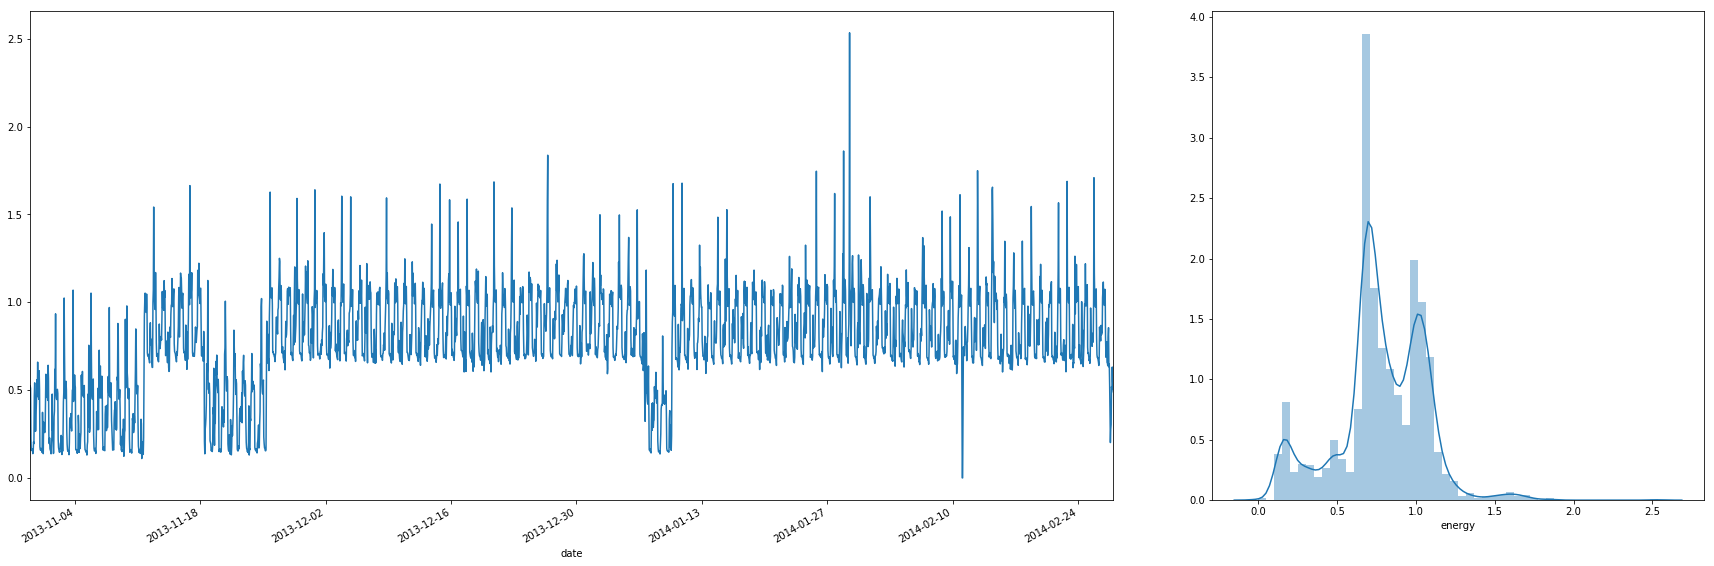

In [34]:
plt.figure(figsize=(30,10)) 
gs = gridspec.GridSpec(1,3)
plt.subplot(gs[0,:-1])

series.plot()
plt.subplot(gs[0,-1])
sns.distplot(series)

In [35]:
from statsmodels.tsa.stattools import periodogram, acf
from statsmodels.tsa.arima_model import ARIMA

In [36]:
import statsmodels.api as sm
from scipy import stats


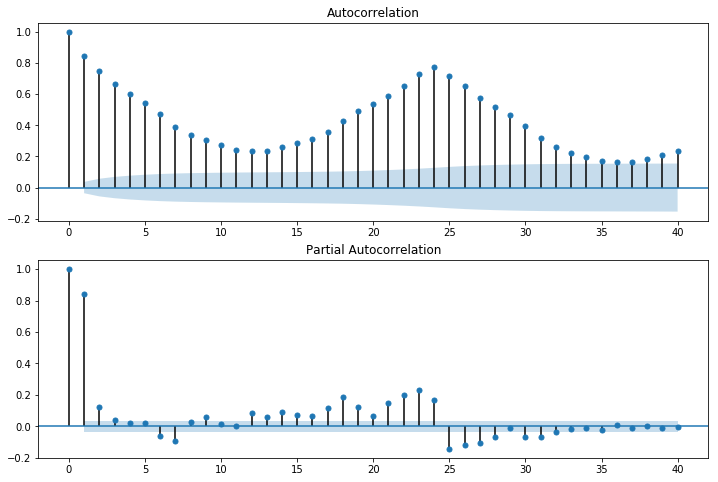

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

In [38]:
arima_mod = sm.tsa.ARIMA(series, (2,1,0)).fit()
print(arima_mod.params)

const            -7.417022e-07
ar.L1.D.energy   -2.120120e-01
ar.L2.D.energy   -9.413931e-02
dtype: float64


In [39]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                 2903
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1319.013
Method:                       css-mle   S.D. of innovations              0.154
Date:                Mon, 16 Apr 2018   AIC                          -2630.027
Time:                        08:58:15   BIC                          -2606.133
Sample:                    10-30-2013   HQIC                         -2621.418
                         - 02-27-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.417e-07      0.002     -0.000      1.000      -0.004       0.004
ar.L1.D.energy    -0.2120      0.018    -11.475      0.000      -0.248      -0.176
ar.L2.D.energy    -0.0941      0.018     -5.093      0.000      -0.130      -0.058
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1261           -3.0585j            3.2592           -0.3061
AR.2           -1.1261           +3.0585j            3.2592            0.3061
-----------------------------------------------------------------------------
"""

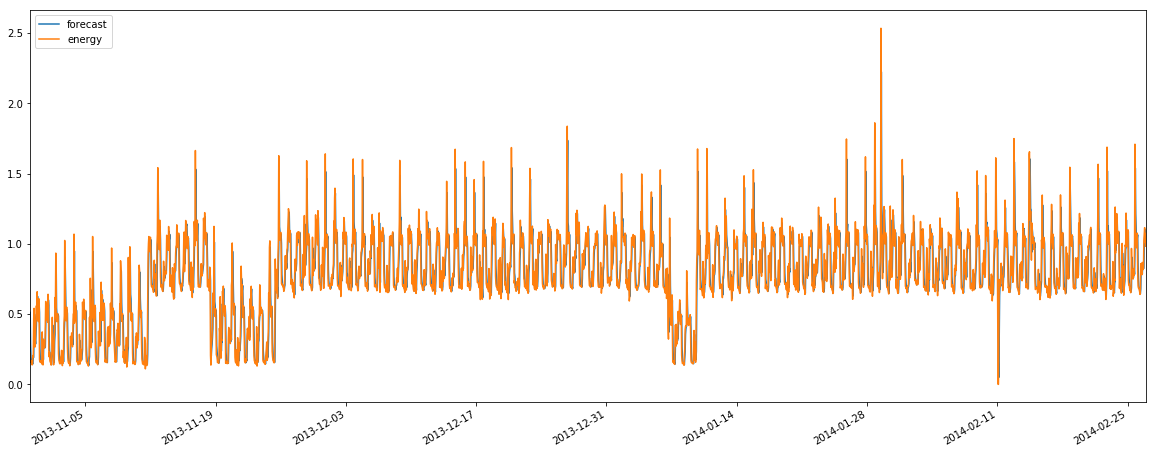

In [40]:
fig, ax = plt.subplots(figsize=(20,8))
fig = arima_mod.plot_predict(start='2013-10-30 02:00:00', end='2014-02-27', ax=ax)
legend = ax.legend(loc='upper left')

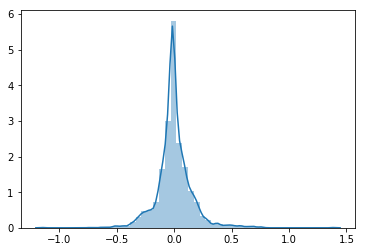

In [41]:
sns.distplot(arima_mod.resid)

### Cluster 1
Using the houshold MAC000349 as a representative for cluster 1, we analyse the series using ARIMA. 

In [42]:
series = df[df['id'] == 'MAC000349']['energy']

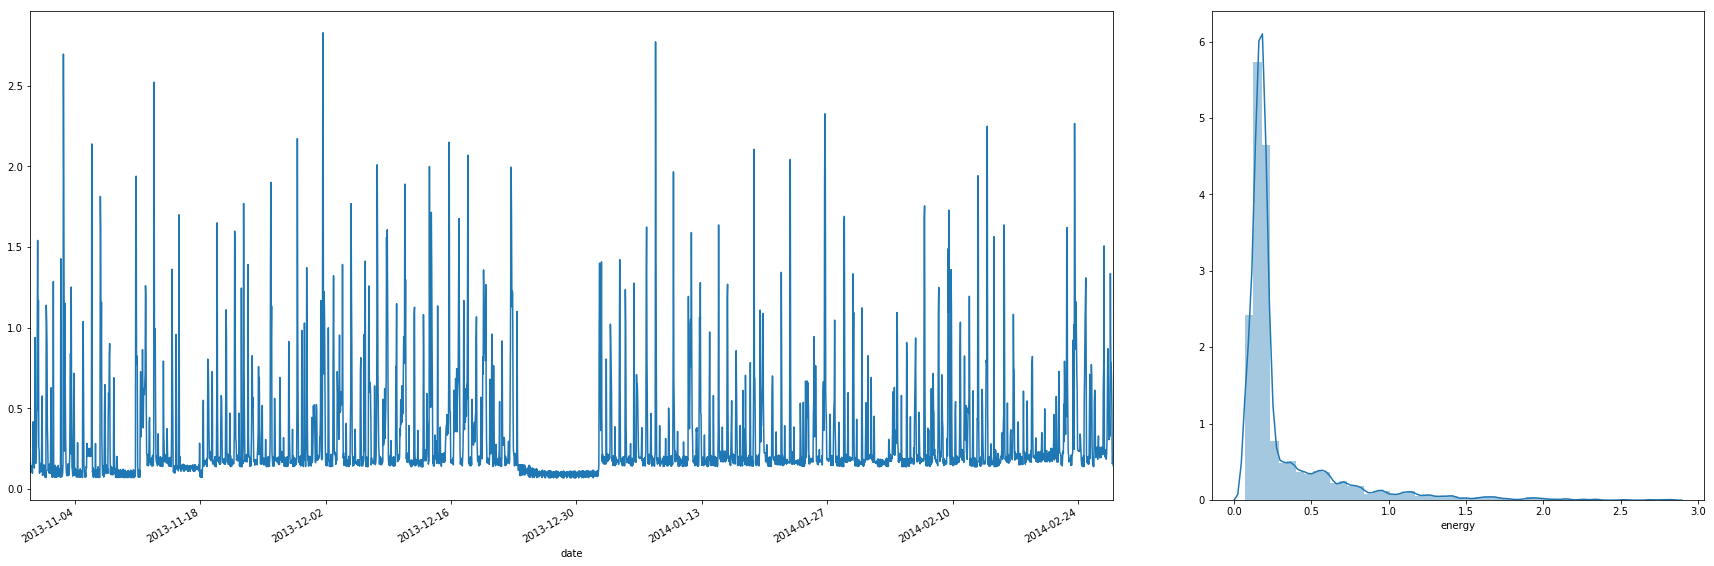

In [43]:
plt.figure(figsize=(30,10)) 
gs = gridspec.GridSpec(1,3)
plt.subplot(gs[0,:-1])
df[df['id'] == 'MAC000349']['energy'].plot()
plt.subplot(gs[0,-1])
sns.distplot(df[df['id']=='MAC000349']['energy'])

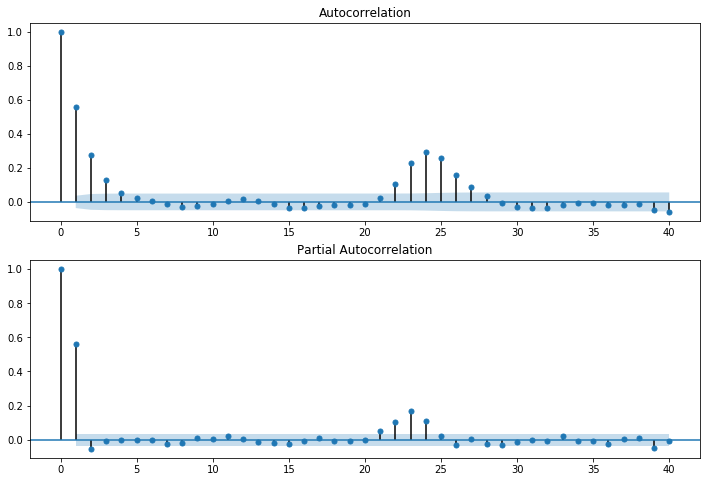

In [44]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

In [45]:
arima_mod = sm.tsa.ARIMA(series, (2,1,0)).fit()
print(arima_mod.params)

const             0.000002
ar.L1.D.energy   -0.211780
ar.L2.D.energy   -0.188716
dtype: float64


In [46]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                 2903
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -635.602
Method:                       css-mle   S.D. of innovations              0.301
Date:                Mon, 16 Apr 2018   AIC                           1279.204
Time:                        08:58:22   BIC                           1303.098
Sample:                    10-30-2013   HQIC                          1287.812
                         - 02-27-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             1.5e-06      0.004      0.000      1.000      -0.008       0.008
ar.L1.D.energy    -0.2118      0.018    -11.621      0.000      -0.247      -0.176
ar.L2.D.energy    -0.1887      0.018    -10.358      0.000      -0.224      -0.153
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5611           -2.2325j            2.3019           -0.2892
AR.2           -0.5611           +2.2325j            2.3019            0.2892
-----------------------------------------------------------------------------
"""

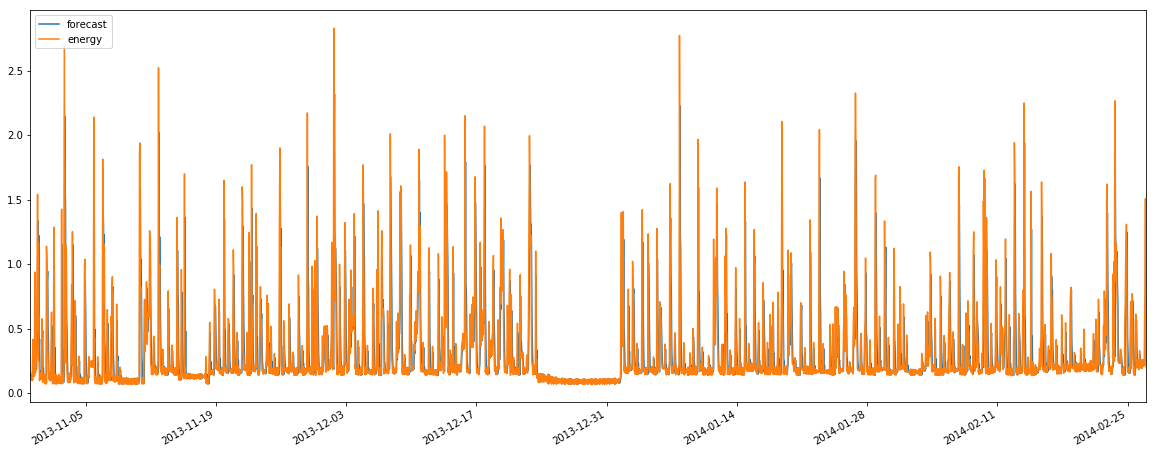

In [47]:
fig, ax = plt.subplots(figsize=(20,8))
fig = arima_mod.plot_predict(start='2013-10-30 01:00:00', end='2014-02-27', ax=ax)
legend = ax.legend(loc='upper left')

### Cluster 2
Using the houshold MAC000034 as a representative for cluster 2, we analyse the series using ARIMA. 

In [48]:
series = df[df['id'] == 'MAC000034']['energy']

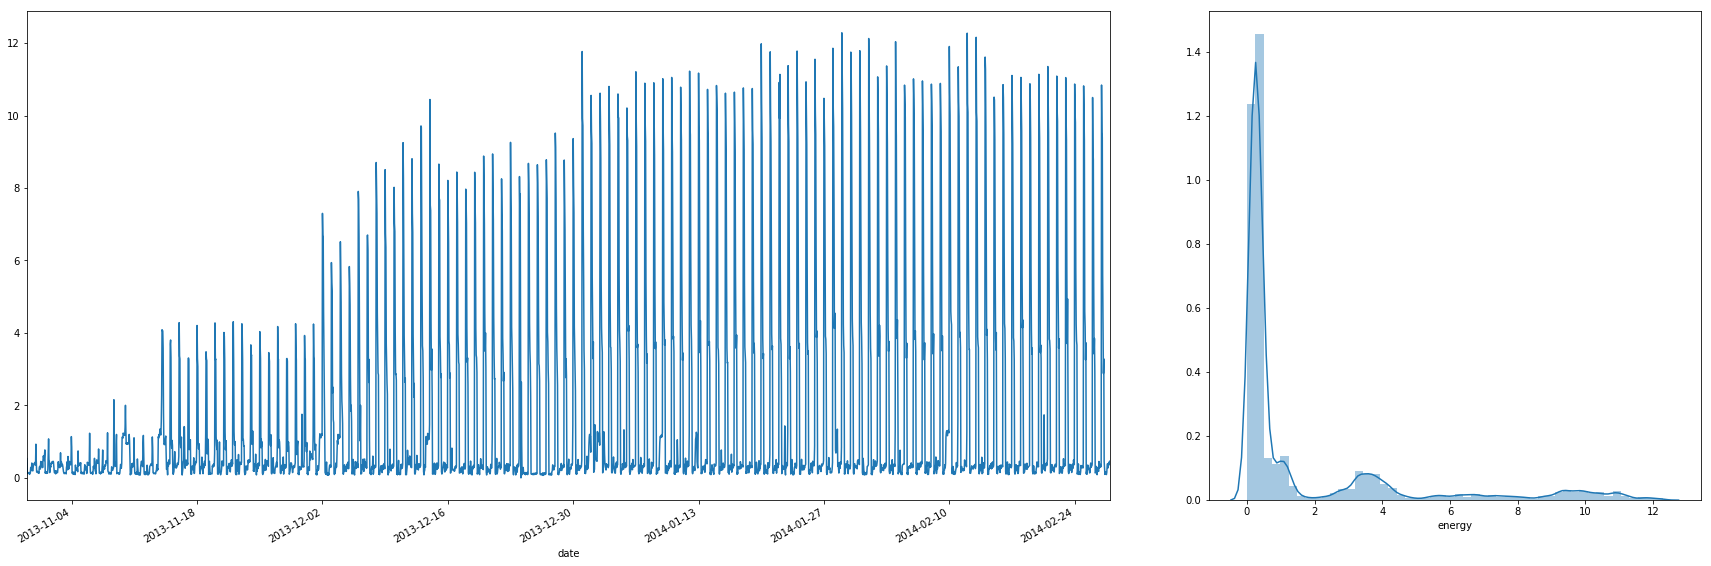

In [49]:
plt.figure(figsize=(30,10)) 
gs = gridspec.GridSpec(1,3)
plt.subplot(gs[0,:-1])
df[df['id'] == 'MAC000034']['energy'].plot()
plt.subplot(gs[0,-1])
sns.distplot(df[df['id']=='MAC000034']['energy'])

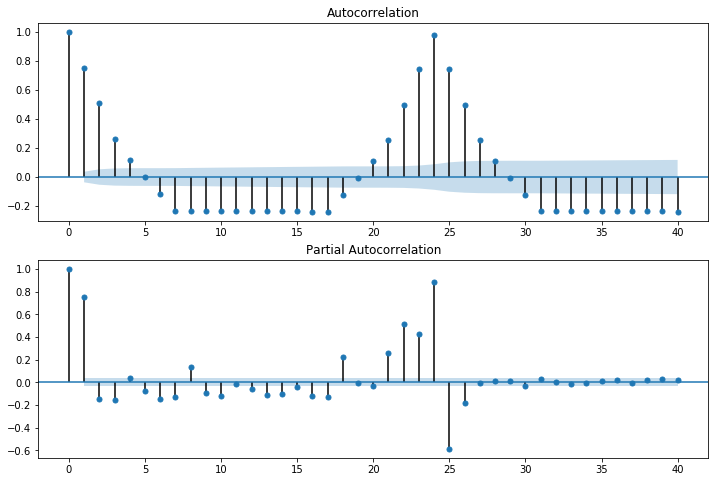

In [50]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

In [51]:
arima_mod = sm.tsa.ARIMA(series, (2,1,0)).fit()
print(arima_mod.params)

const            -0.000022
ar.L1.D.energy    0.002142
ar.L2.D.energy   -0.004727
dtype: float64


In [52]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                 2903
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6080.624
Method:                       css-mle   S.D. of innovations              1.965
Date:                Mon, 16 Apr 2018   AIC                          12169.248
Time:                        08:58:29   BIC                          12193.142
Sample:                    10-30-2013   HQIC                         12177.857
                         - 02-27-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.192e-05      0.036     -0.001      1.000      -0.071       0.071
ar.L1.D.energy     0.0021      0.019      0.115      0.908      -0.034       0.039
ar.L2.D.energy    -0.0047      0.019     -0.255      0.799      -0.041       0.032
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2266          -14.5428j           14.5446           -0.2475
AR.2            0.2266          +14.5428j           14.5446            0.2475
-----------------------------------------------------------------------------
"""

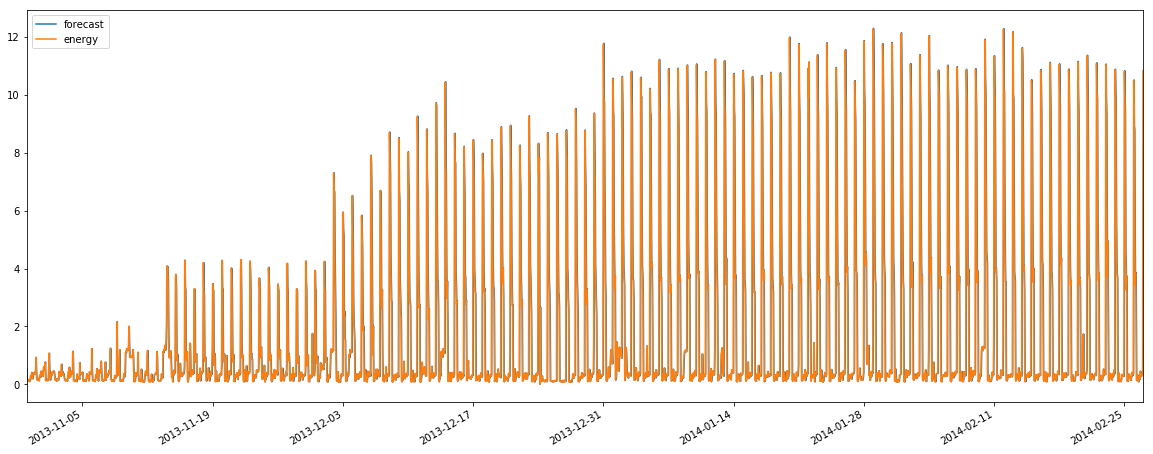

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
fig = arima_mod.plot_predict(start='2013-10-30 01:00:00', end='2014-02-27', ax=ax)
legend = ax.legend(loc='upper left')

### Cluster 3
Using the houshold MAC002321 as a representative for cluster 3, we analyse the series using ARIMA. 

In [54]:
series = df[df['id'] == 'MAC002321']['energy']

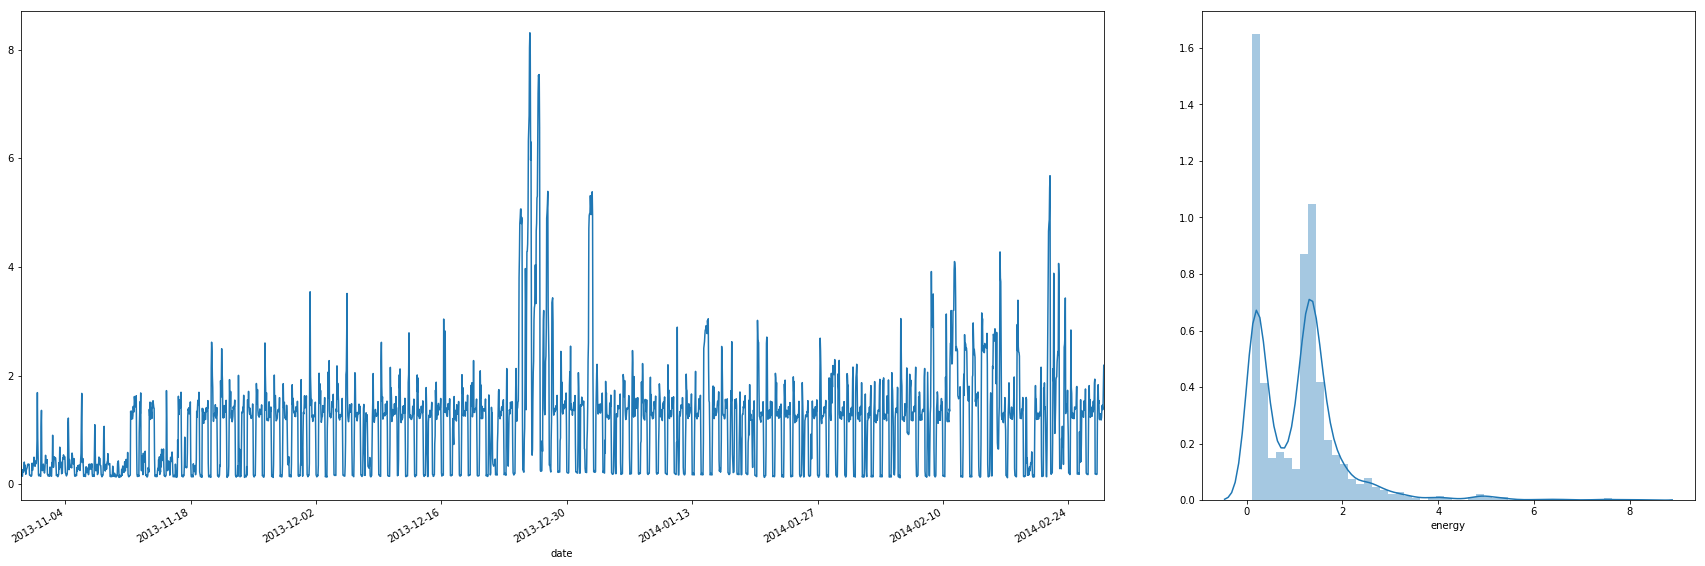

In [55]:
plt.figure(figsize=(30,10)) 
gs = gridspec.GridSpec(1,3)
plt.subplot(gs[0,:-1])
df[df['id'] == 'MAC002321']['energy'].plot()
plt.subplot(gs[0,-1])
sns.distplot(df[df['id']=='MAC002321']['energy'])

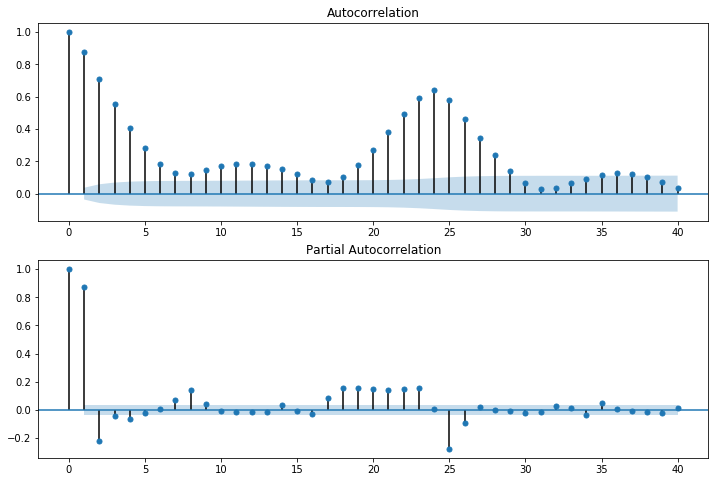

In [56]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

In [57]:
arima_mod = sm.tsa.ARIMA(series, (2,1,0)).fit()
print(arima_mod.params)

const             0.000647
ar.L1.D.energy    0.153795
ar.L2.D.energy   -0.049749
dtype: float64


In [58]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                 2903
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1965.499
Method:                       css-mle   S.D. of innovations              0.476
Date:                Mon, 16 Apr 2018   AIC                           3938.998
Time:                        08:58:35   BIC                           3962.892
Sample:                    10-30-2013   HQIC                          3947.607
                         - 02-27-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0006      0.010      0.066      0.948      -0.019       0.020
ar.L1.D.energy     0.1538      0.019      8.297      0.000       0.117       0.190
ar.L2.D.energy    -0.0497      0.019     -2.684      0.007      -0.086      -0.013
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5457           -4.2085j            4.4834           -0.1940
AR.2            1.5457           +4.2085j            4.4834            0.1940
-----------------------------------------------------------------------------
"""

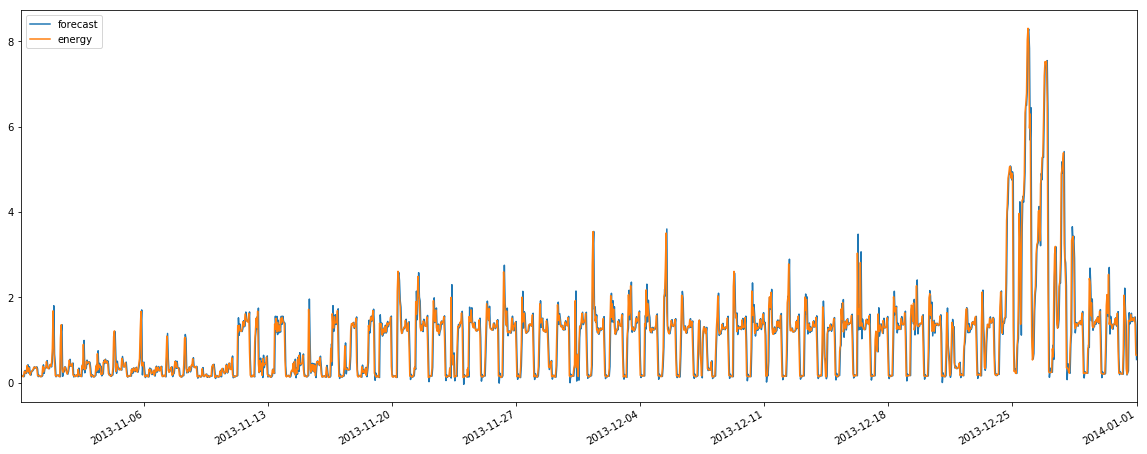

In [59]:
fig, ax = plt.subplots(figsize=(20,8))
fig = arima_mod.plot_predict(start='2013-10-30 01:00:00', end='2014-01-01', ax=ax)
legend = ax.legend(loc='upper left')